In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
from starfish import data
import pprint
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [28]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_4c/*'
files = glob.glob(out_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for n in files:
        name = n.split('/')[-1]
        f.write(base_str + f'run_name={name}' + ' \n')

In [53]:
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70
bench_df = crop_df(bench_df, np.s_[:,:,500:1500,500:1500], px_size_zyx=[100., 100., 100.])
bench_df['z'] = bench_df['z']/1000

17130008


In [54]:
len(bench_df)

8835

In [30]:
sweep_name = 'merfish_sweep_mop_4c'
# sweep_name = 'merfish_sweep_ci_15_'

df_dict = {}
# df_dict['istdeco'] = istdeco_df
df_dict['bench'] = bench_df

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}*'):
    dec_df = pd.read_csv(f)
    df_dict['dec_'+f.split(sweep_name)[-1].split('.csv')[0]] = dec_df[dec_df['gene'] != 'MALAT1']

In [55]:
res_df = df_dict['dec__enabled:Falsexpsf_noise:0.0xscale:300xint_option:1']
res_df['z'] = res_df['z']/100

In [65]:
res_single = remove_doublets(res_df)

KeyboardInterrupt: 

In [66]:
# res_sub_s = res_single.nsmallest(10000, 'comb_sig')
res_sub_m = res_df.nsmallest(10000, 'comb_sig')

In [67]:
res_single = remove_doublets(res_sub_m)

In [69]:
_,matches,shift = matching(bench_df, res_single, tolerance=250, print_res=True, allow_multiple_matches=True)

Recall: 0.510
Precision: 0.577
Jaccard: 37.097
RMSE_vol: 51.662
Eff_3d: 32.000
FN: 4331.0 FP: 3306.0
Num. matches: 4504.000
Shift: 1.92,-0.16,0.63


In [70]:
_,matches,shift = matching(bench_df, res_single, tolerance=250, print_res=True, allow_multiple_matches=False)

Recall: 0.508
Precision: 0.575
Jaccard: 36.940
RMSE_vol: 51.642
Eff_3d: 31.858
FN: 4345.0 FP: 3320.0
Num. matches: 4490.000
Shift: 1.89,-0.09,0.63


8835 7810


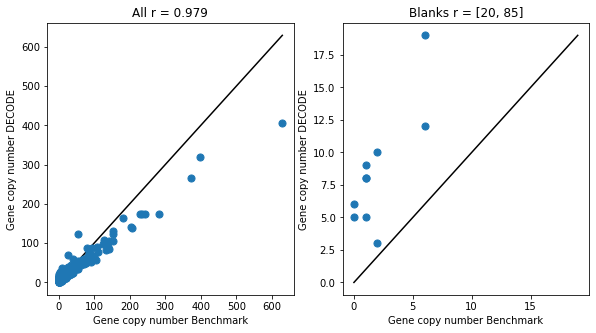

In [71]:
plot_gene_panels(res_single.nsmallest(9000, 'comb_sig'), bench_df, targets)

Text(0.5, 0, '# localizations matched')

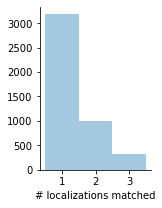

In [63]:
plt.figure(figsize=(2,3))
sns.distplot(matches.groupby('loc_idx_tar')['loc_idx_tar'].count(), bins=[0.5,1.5,2.5,3.5],kde=False)
sns.despine()
plt.xlabel('# localizations matched')

In [25]:
fns = ist_sub.loc[~ist_sub['loc_idx'].isin(matches['loc_idx_tar'])]
tps = ist_sub.loc[ist_sub['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_sub_s.loc[~res_sub_s['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.03122398001665279
0.7789317507418397
0.47155460906601765


In [26]:
gene_counts = DF(data=None, index=targets)
gene_counts['dec'] = res_sub_s.groupby('gene')['gene'].count()
gene_counts['ist'] = ist_sub.groupby('gene')['gene'].count()
gene_counts['tps'] = tps.groupby('gene')['gene'].count()
gene_counts['fps'] = fps.groupby('gene')['gene'].count()
gene_counts['fns'] = fns.groupby('gene')['gene'].count()
gene_counts = gene_counts.fillna(0)

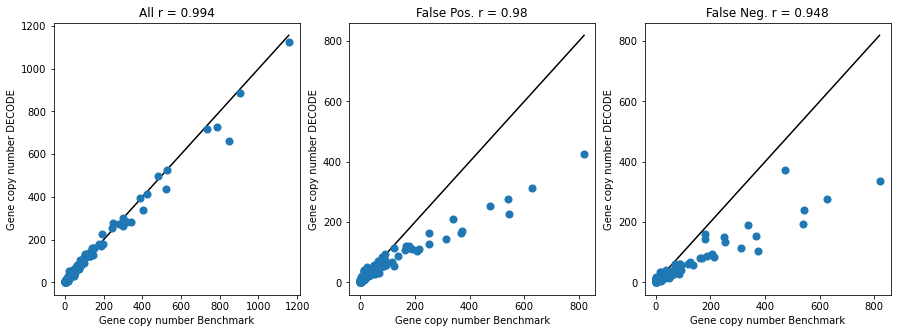

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_gene_numbers(gene_counts['ist'].values, gene_counts['dec'].values, 'All', log=False)
plt.subplot(132)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fps'].values, 'False Pos.', log=False)
plt.subplot(133)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fns'].values, 'False Neg.', log=False)

Text(0.5, 1.0, 'Corr. 0.948')

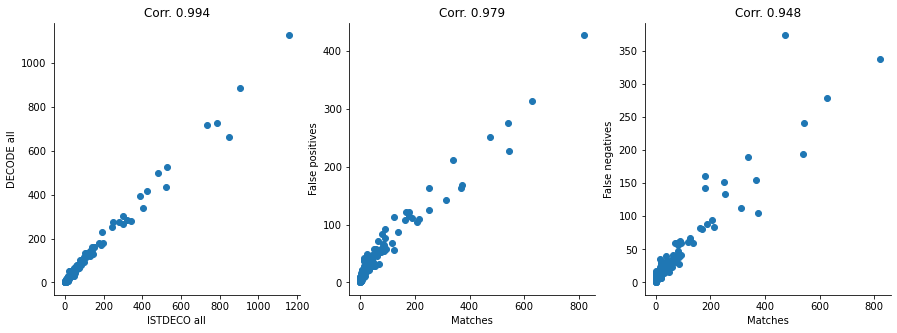

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(gene_counts['ist'].values, gene_counts['dec'].values)
plt.plot([0,0],[len(gene_counts['ist'].values),len(gene_counts['dec'].values)])
sns.despine()
plt.xlabel('ISTDECO all')
plt.ylabel('DECODE all')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['ist'].values, gene_counts['dec'].values)[0,1])[:5])
plt.subplot(132)
plt.scatter(gene_counts['tps'].values, gene_counts['fps'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False positives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fps'].values)[0,1])[:5])
plt.subplot(133)
plt.scatter(gene_counts['tps'].values, gene_counts['fns'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False negatives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fns'].values)[0,1])[:5])


In [503]:
matches, bench_match = match_bench(ist_sub, bench_sub)

[105.19045625784847, 108.79028882377564, 0.0]
Recall: 0.828
Precision: 0.693
Jaccard: 60.577
RMSE_vol: 86.406
Eff_3d: 41.513
FN: 2160.0 FP: 4605.0
Num. matches: 10395.000
Shift: 1.97,2.22,0.00


In [441]:
matches, bench_match = match_bench(res_sub, ist_sub)

[-47.818190794681755, -47.39166323962233, -4.50561606939003]
Recall: 0.656
Precision: 0.656
Jaccard: 48.846
RMSE_vol: 66.489
Eff_3d: 38.993
FN: 5155.0 FP: 5155.0
Num. matches: 9845.000
Shift: -0.27,-0.46,-0.02


In [961]:
matches, bench_match = match_bench(res_sub, res_sub)

[0.0, 0.0, 0.0]
Recall: 1.000
Precision: 1.000
Jaccard: 100.000
RMSE_vol: 0.000
Eff_3d: 100.000
FN: 0.0 FP: 0.0
Num. matches: 15000.000
Shift: 0.00,0.00,0.00


In [29]:
plot_gene_panels(res_sub, bench_sub, targets, matches)

NameError: name 'res_sub' is not defined

In [77]:
# test1 = pd.read_csv('../data/results/MERFISH/test1.csv')
# test2 = pd.read_csv('../data/results/MERFISH/test.csv')
# test1 = test1[test1['gene'] != 'MALAT1']
# test2 = test2[test2['gene'] != 'MALAT1']

In [37]:
par_dict = {}

for i,k in enumerate(df_dict):
    if 'dec_' in k:
        if len(df_dict[k]) > 0:
            par_dict[k] = [df_dict[k], 'comb_sig', True]
#             par_dict[k+'_s'] = [remove_doublets(df_dict[k]), 'comb_sig', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=25000)
    roc_dict[k] = [x, y]

In [38]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [73]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,200], range_x=[0,15000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

KeyError: 'dec_full'

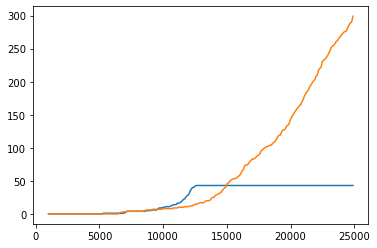

In [26]:
plt.plot(df['x'], df['baseline'], label='baseline')
plt.plot(df['x'], df['ISTDECO'], label='ISTDECO')
plt.plot(df['x'], df['dec_full'], label='DECODE Full')
plt.plot(df['x'], df['dec_single'], label='DECODE Iso.')

plt.legend(frameon=False)
sns.despine()
plt.xlim(0,20000)
plt.ylim(0,75)
plt.xlabel("Number detected genes")
plt.ylabel("Number detected blanks")

In [401]:
# plt.figure(figsize=(15,10))

# for i in range(3):

#     ints = df_dict[f'dec_old_loss:0xint_option:{i+1}xseed:1'].nsmallest(15000, 'code_err').loc[:,int_keys].values
#     ps = df_dict[f'dec_old_loss:0xint_option:{i+1}xseed:1'].nsmallest(15000, 'code_err').loc[:,p_keys].values

#     s_ints = np.take_along_axis(ints, ps.argsort(-1)[:,::-1], 1)[:,:4]
#     s_ps = np.take_along_axis(ps, ps.argsort(-1)[:,::-1], 1)
    
#     print(np.var(s_ints, -1).mean())

#     plt.subplot(1,3,i+1)
#     plt.plot(np.var(s_ints, -1))
# #     for i in range(5000,5050):
# #         plt.plot(s_ints[i])
# #     plt.ylabel('intensity')
# #     plt.xlabel('four highest probablities')

In [86]:
# import seaborn as sns

# colmap = sns.color_palette("husl", 12)
# n_dec = len(df_dict) - 2
# cols = colmap[:2] + 2*colmap[2:2+n_dec]

# plt.figure(figsize=(10,8))

# for i,k in enumerate(roc_dict):
#     x, y = roc_dict[k]
#     ls = '--' if 'nq' in k else None
#     plt.plot(x, y, label=k, color=cols[i], linestyle=ls)
    
# plt.legend()
# plt.ylim(0, 100)
# plt.xlim(0, 24000)
# sns.despine()

In [68]:
df_dict.keys()

dict_keys(['istdeco', 'bench', 'dec_int_option:1', 'dec_int_option:3', 'dec_int_option:2'])

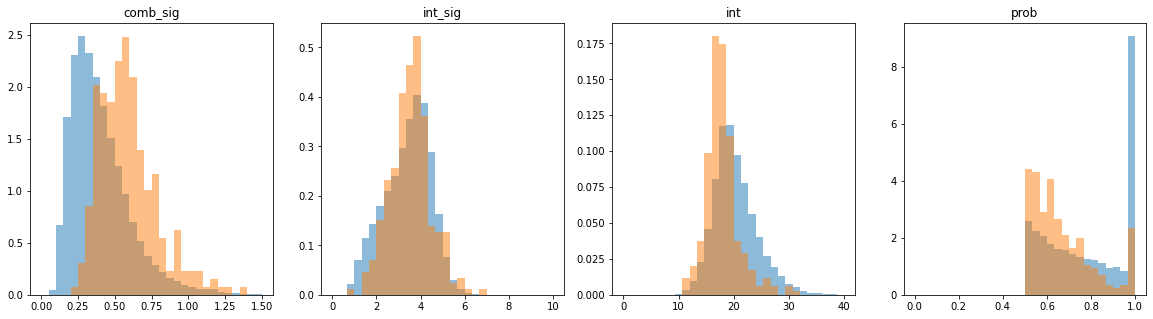

In [606]:
res_df = df_dict['dec_psf_noise:0.0xrate_fac:3.0']

metrics = ['comb_sig','int_sig','int', 'prob']
bins = [np.linspace(0,1.5,31), np.linspace(0,10,31), np.linspace(0,40,31), np.linspace(0,1,31), np.linspace(0,50,31), np.linspace(0,1.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [399]:
# plt.scatter(res_df['code_err'], res_df['net_qual'])

In [32]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

In [288]:
df_dict.keys()

dict_keys(['istdeco', 'bench', 'dec_psf_noise:0.15xenabled:False', 'dec_psf_noise:0.15xenabled:True', 'dec_psf_noise:0.4xenabled:True', 'dec_psf_noise:0.3xenabled:False', 'dec_psf_noise:0.4xenabled:False', 'dec_psf_noise:0.3xenabled:True'])

In [600]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'] #.smallest(15000, 'comb_sig')

In [35]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

In [36]:
import mpld3
from mpld3 import plugins

25630


(600.0, 750.0)

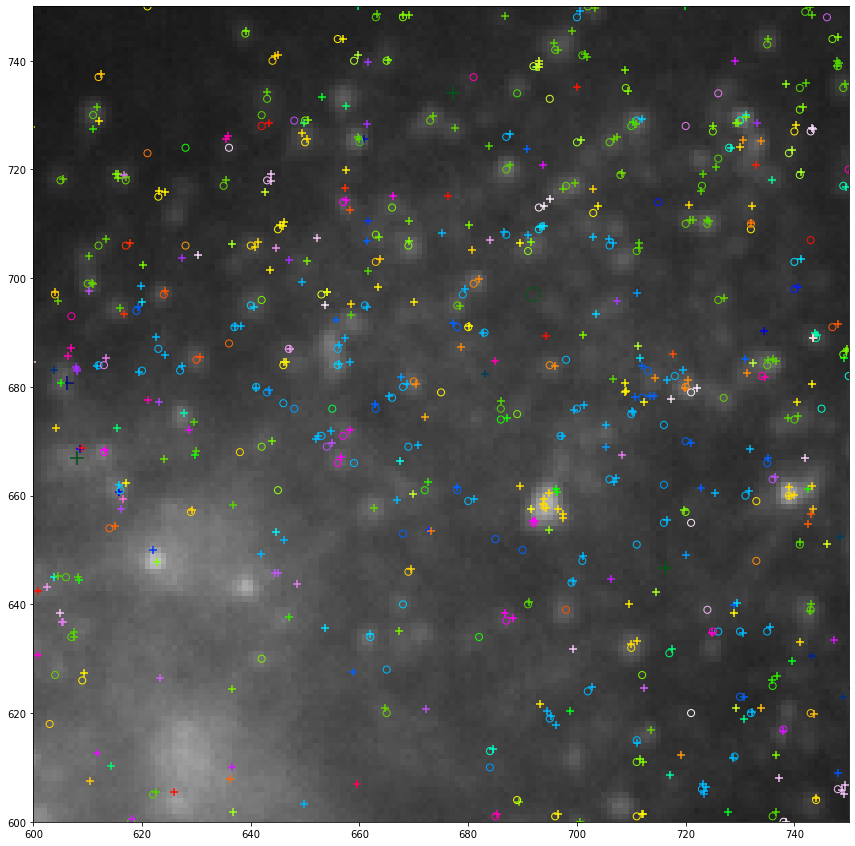

In [62]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_df)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

21392


(600.0, 750.0)

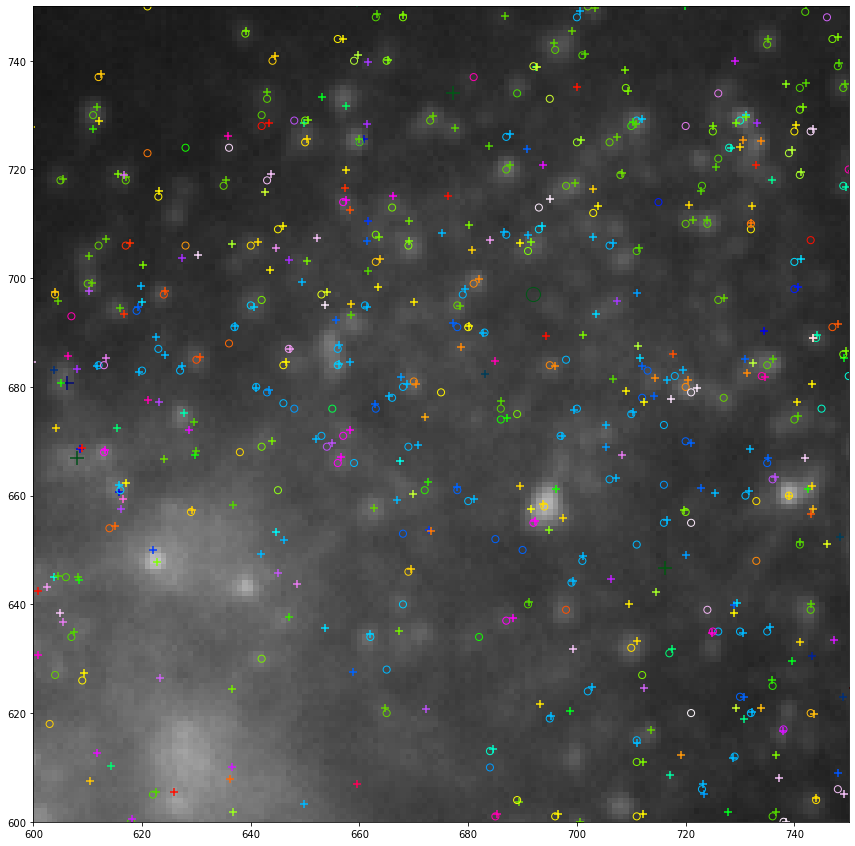

In [63]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [663]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'].nsmallest(17000, 'comb_sig')
# res_sub = df_dict['dec_min_int_sig:0.0xint_fac:0.1'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

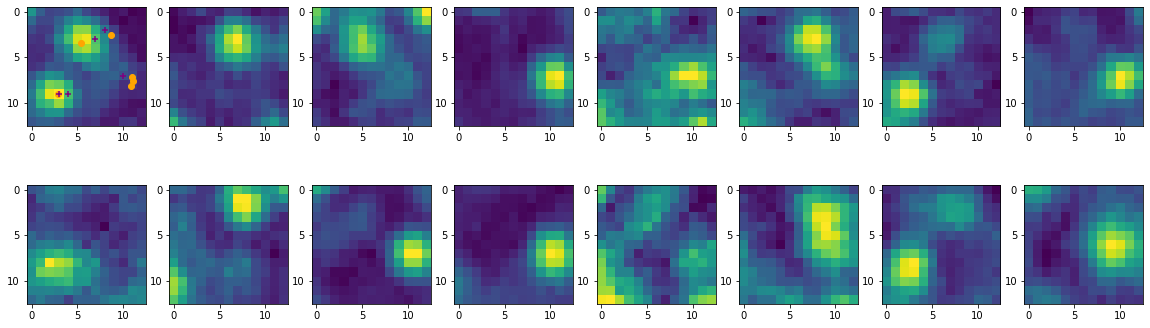

In [664]:
vol, crop = extract_roi(img_stack[None], torch.IntTensor([514,740,0]), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [506]:
img_stack = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff')[:,0]

In [507]:
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=5, size_z: int=10):
    res = []
    tot_size = torch.Size([1, 16, size_xy*2+1, size_xy*2+1])
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [307]:
matches, bench_match = match_bench(ist_sub, res_sub)

[43.37100571381241, 42.2713849205034, 6.282809199047704]
Recall: 0.380
Precision: 0.805
Jaccard: 34.834
RMSE_vol: 69.581
Eff_3d: 26.128
FN: 19685.0 FP: 2918.0
Num. matches: 12082.000
Shift: 1.29,1.79,-0.02


In [534]:
res_sub['z'].max()

149.10715

In [535]:
z_vols = [[] for _ in range(20)]

In [536]:
sub = res_sub.nsmallest(10000, 'comb_sig')
for i in tqdm(range(len(sub))):
    b_loc = nm_to_px(sub.iloc[i])
    vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)
    volm = cpu(vol[0,code_ref[b_loc['code_inds']].nonzero()[0]].sum(0))
    z_vols[int((b_loc['z']+0.5)*10)].append(volm/volm.max())

100%|████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1043.66it/s]


(array([ 629., 1383., 2260., 2674., 2324., 2011., 1615., 1477., 1404.,
        1223.]),
 array([-99.78957 , -79.880013, -59.970456, -40.060899, -20.151342,
         -0.241785,  19.667772,  39.577329,  59.486886,  79.396443,
         99.306   ]),
 <BarContainer object of 10 artists>)

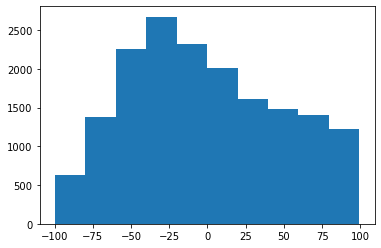

In [607]:
plt.hist(res_sub['z'])

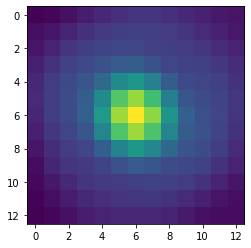

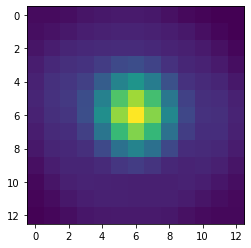

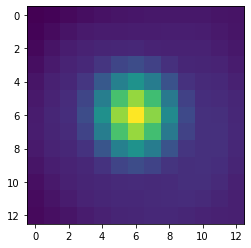

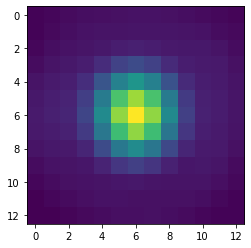

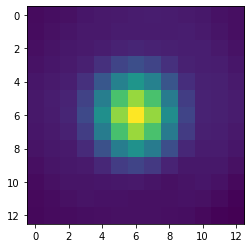

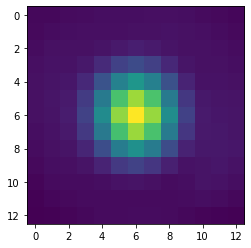

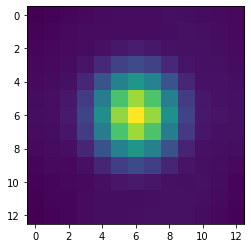

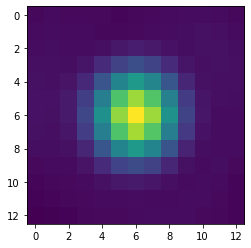

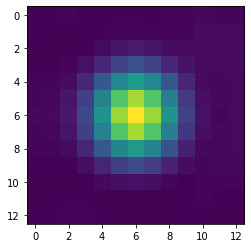

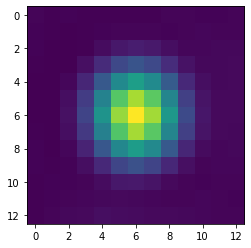

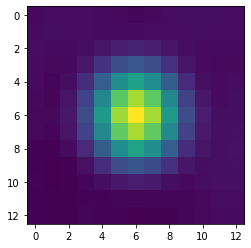

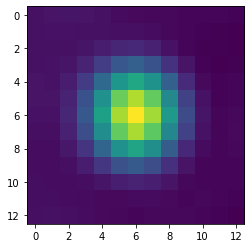

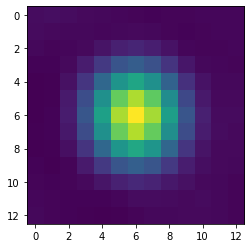

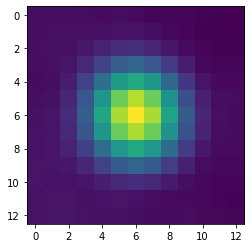

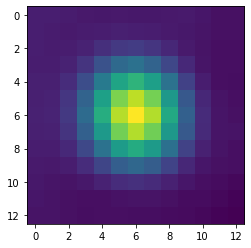

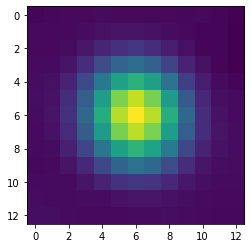

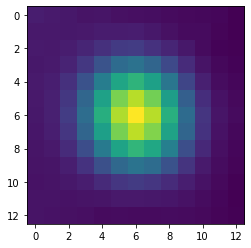

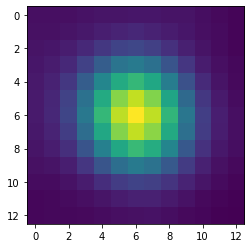

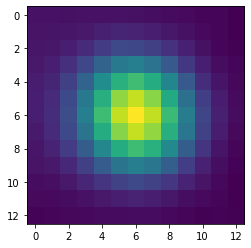

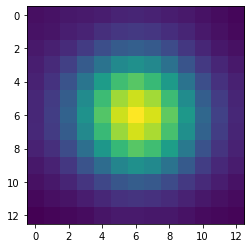

In [538]:
for i in range(len(z_vols)):
    mvol = np.stack(z_vols[i]).mean(0)
    plt.imshow(mvol)
    plt.show()

279


,loc_idx,frame_idx,code_inds,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig,gene
279,296,0,7,356.51113,859.46805,0.608987,0.529195,14.781097,2.957316,64.50154,44.23358,41.745464,0.886552,Blank-7


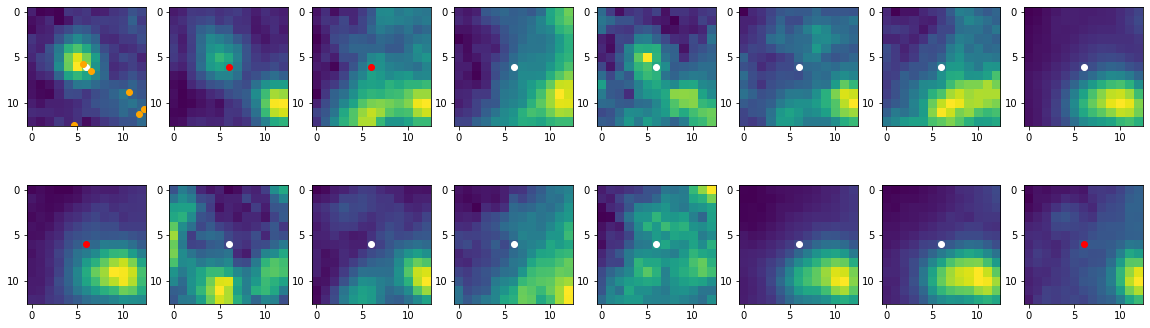

In [550]:
# Random predictions 
sub = res_sub.nsmallest(20000, 'comb_sig')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [547]:
ind = np.random.randint(0, len(sub))
print(ind)
ind = 855
b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

152


IndexError: single positional indexer is out-of-bounds

In [ ]:
# small psf : 855
# large psf: 4293, 5206

KeyError: 'tar_idx'

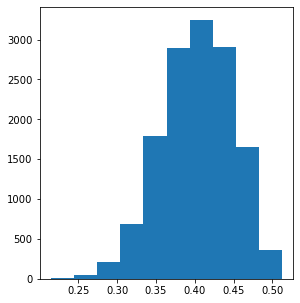

In [279]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist(bench_match['av_distance'], density=False)
_ = plt.hist(bench_match['av_distance'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5)
_ = plt.hist(bench_match['av_distance'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5)

plt.subplot(122)
_ = plt.hist(bench_match['total_magnitude'], density=False, bins=np.linspace(0,500,101))
_ = plt.hist(bench_match['total_magnitude'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5)
_ = plt.hist(bench_match['total_magnitude'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5)

In [36]:
fn_inds = fns['loc_idx'].values
# btps = bench_match.loc[bench_match['loc_idx'].isin(matches['tar_idx'])]
# fn_inds = btps['loc_idx'].values

,Unnamed: 0,barcode,barcode_id,fov_id,total_magnitude,area,is_exact,error_bit,error_dir,av_distance,x,y,wx,wy,gene,code,frame_idx,loc_idx,int,z
3034,12430,1010000000000110,49,0,66.170219,9,0,2,0,0.400019,1117.047144,1646.129023,1117.792847,1647.254639,RNF169,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]",0,3034,66.170219,0.5


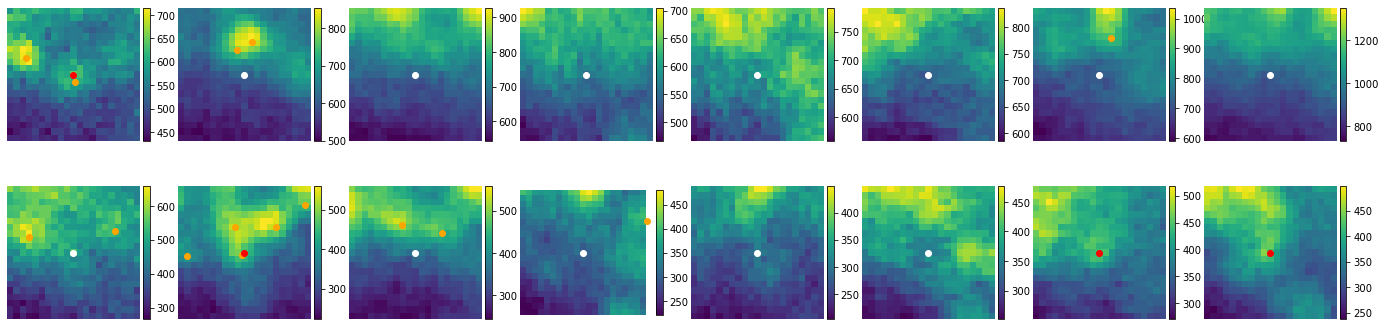

In [37]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]
# ind = 1607

b_loc = nm_to_px(bench_match[bench_match['loc_idx'] == ind]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(24,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    im = plt.imshow(vol[0,i])
    plt.axis('off')
    add_colorbar(im)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)

In [44]:
blank_df = res_sub[res_sub['gene'].str.contains('Blank')]
blank_df = blank_df.sort_values('logdist', ascending=False)

In [61]:
blank_df.groupby('cc')['cc'].count().values / res_sub.groupby('cc')['cc'].count().values*100

array([2.34814671, 0.35903062, 2.15889465])

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig,group_idx,code,cc,rmses,logdist,gene
31040,36361,0,209.70791,552.50746,0.5,0.861657,6.397343,0.619625,29.323174,20.414253,100.0,1.061913,9485,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,6.431063,-9.050423,Blank-9


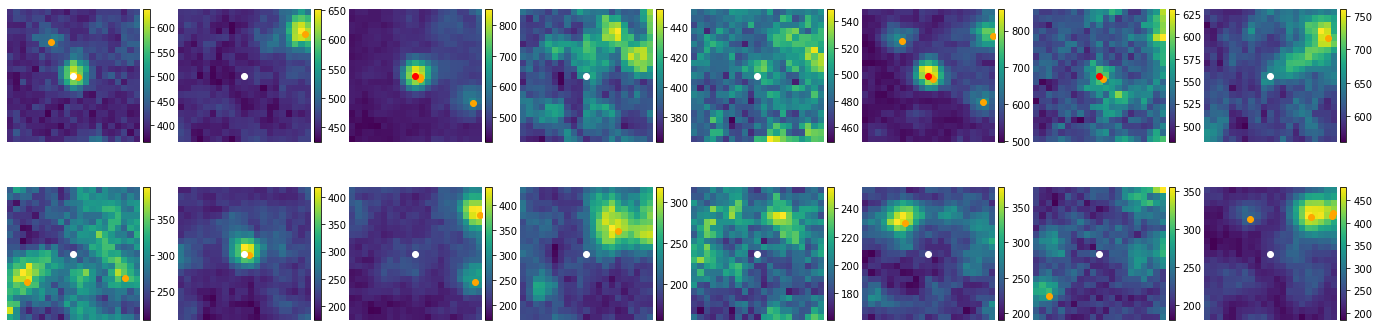

In [51]:
b_loc = nm_to_px(blank_df).iloc[2]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(24,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    im = plt.imshow(vol[0,i])
    plt.axis('off')
    add_colorbar(im)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')
    color = 'red' if b_loc['code'][i] else 'white'
    plt.scatter([10],[10], color=color)

In [35]:
b_m = bench_match[bench_match['loc_idx'] == m['tar_idx']]
p_m = res_df_filt[res_df_filt['loc_idx'] == m['pred_idx']]

NameError: name 'm' is not defined

In [ ]:
display(p_m)
display(b_m)

In [809]:
for c in range(2):
    for i in range(8):

        img = load_tiff_image(image_paths[i])
        preds_px = nm_to_px(pred_df[pred_df['frame_idx']==(i+c*8)])
        plt.figure(figsize=(25,25))
        plt.imshow(img[c,0])
        plt.title('i'+str(i)+'c'+str(c))

        plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.5)
        plt.show()

NameError: name 'pred_df' is not defined

In [ ]:
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

In [ ]:
# How many blank-genes (false positives) do we accept?
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

# Download benchmark
bench_raw = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv',\
                    dtype={'barcode': object})

# Filter benchmark

ns = []

for i in range(1,101):
    bench = bench_raw[bench_raw['area'] > 3]
    thresh = bench[bench['gene'].isin(non_targeted_names)]['total_magnitude'].nlargest(i).iloc[-1]
    bench = bench[bench['total_magnitude'] > thresh]
    ns.append(len(bench))

In [282]:
zoe_ps = np.array([81,88,85,79,65,69,67,70,63,80,80,74,69,85,71,80,70,81,80,79,89,84,87,79,80,90,80,78,81,83,76,100,85,95,87,91,76,73,95,88,79,67,90,89,82,87,88,76,81,87,85,78,83,84,84,76,75,88,81,79,87,91,83,91,75,86])
print(np.mean(zoe_ps))

81.28787878787878


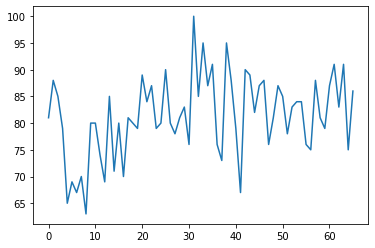

In [302]:
plt.plot(zoe_ps)